In [1]:
# import classy module

import chaospy
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import regfortran___2
import euclidemu2 as ee2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
import scipy.interpolate
from scipy.optimize import fsolve
from scipy.interpolate import CubicSpline
import time
import math
import numpoly
from scipy.fft import fft, dct
from scipy import integrate
from scipy import interpolate
from scipy.fftpack import dst, idst
from scipy.integrate import simps
from scipy.integrate import trapz

In [2]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 150
rcParams["font.size"] = 10

In [3]:
uniform =chaospy.Uniform(-1, 1)
uniform1 =chaospy.Uniform(-1, 1)
uniform2 = chaospy.Uniform(-1, 1)
uniform3 = chaospy.Uniform(-1, 1)
uniform4 = chaospy.Uniform(-1, 1)


joint = chaospy.J(uniform, uniform1,uniform2,uniform3,uniform4)
expansion9 = chaospy.generate_expansion(11, joint, cross_truncation=1.0, graded=True)

In [4]:
def smooth_bao(ks, pk):
    
 
    
    n = 15
    dst_ks = np.linspace(1e-4, 5, 2**n) #10
    logks = np.log(dst_ks)
    
    
    spline_loglog_pk_2 = interpolate.interp1d(np.log(ks), np.log(pk), kind='linear', fill_value='extrapolate')
    spline_loglog_pk2 = spline_loglog_pk_2(np.log(np.linspace(1e-4, 5, 2**n)))
    
    spline_loglog_pk = interpolate.splrep(np.log(np.linspace(1e-4,5, 2**n)), spline_loglog_pk2, s=0)    
        
    logkpk = np.log10(dst_ks * np.exp(interpolate.splev(np.log(dst_ks), spline_loglog_pk, der=0, ext=0)))
    sine_transf_logkpk = dst(logkpk, type=2)# dst(logkpk, type=2, norm='ortho')
    odds = [] # odd entries
    evens = [] # even entries
    even_is = [] # odd indices
    odd_is = [] # even indices
    all_is = [] # all indices
    for i, entry in enumerate(sine_transf_logkpk):
        all_is.append(i)
        if i%2 == 0:
            even_is.append(i)
            evens.append(entry)
        else:
            odd_is.append(i)
            odds.append(entry)
    odd_is=np.array(odd_is)
    even_is=np.array(even_is)
    odds=np.array(odds)
    evens=np.array(evens)
 

    odd_is = np.array(odd_is)
    even_is = np.array(even_is)
    
    
    odds_interp = interpolate.splrep(odd_is, odds, s=0) 
    evens_interp = interpolate.splrep(even_is, evens, s=0) 
    

    
    
    d2_odds =interpolate.splev(odd_is, odds_interp, der=2, ext=0)    
    d2_evens =interpolate.splev(even_is, evens_interp, der=2, ext=0)
    
    
    
    d2_odds_1 =interpolate.splev(odd_is +2, odds_interp, der=2, ext=0) 
    d2_evens_1 =interpolate.splev(even_is +2, evens_interp, der=2, ext=0)
   


    d2_odds_2 =interpolate.splev(odd_is - 2, odds_interp, der=2, ext=0)
    d2_evens_2 =interpolate.splev(even_is - 2 , evens_interp, der=2, ext=0)
    
   
    
    
    
    d2_odds_avg = (d2_odds + d2_odds_2 + d2_odds_1)/3
  

    d2_evens_avg = (d2_evens + d2_evens_2 + d2_evens_1)/3 

    
    
    imin_even = 50+np.argmax(d2_evens_avg[50:150]) -9
    
    imax_even = 50+np.argmin(d2_evens_avg[50:150])+36

    imin_odd = 50+np.argmax(d2_odds_avg[50:150])-9

    imax_odd = 50+np.argmin(d2_odds_avg[50:150])+37

    
    
        
    
    even_is_removed_bumps = np.concatenate((even_is[:imin_even], even_is[imax_even:]))
    odd_is_removed_bumps = np.concatenate((odd_is[:imin_odd], odd_is[imax_odd:]))

    evens_removed_bumps = np.concatenate((evens[:imin_even], evens[imax_even:]))
    odds_removed_bumps = np.concatenate((odds[:imin_odd], odds[imax_odd:]))

    
     

    
    
 

    even_holed_cs = interpolate.splrep(even_is_removed_bumps, evens_removed_bumps * (even_is_removed_bumps+1)**2, s=0)
    odd_holed_cs = interpolate.splrep(odd_is_removed_bumps, odds_removed_bumps * (odd_is_removed_bumps+1)**2, s=0)
  
    
    evens_treated = interpolate.splev(even_is, even_holed_cs, der=0, ext=0) / (even_is + 1)**2
    odds_treated = interpolate.splev(odd_is, odd_holed_cs, der=0, ext=0) / (odd_is + 1)**2
    treated_transform = []
    for odd, even in zip(odds_treated, evens_treated):
        treated_transform.append(even)
        treated_transform.append(odd)
    treated_transform=np.array(treated_transform)    
    treated_logkpk =idst(treated_transform, type=2)/ (2 * len(treated_transform)) # idst(treated_transform, type=2, norm='ortho')
    pk_nw = 10**(treated_logkpk)/dst_ks
    
    k_highk = ks[ks > 4]
    p_highk = pk[ks > 4]

    k_extended = np.concatenate((dst_ks[dst_ks < 4], k_highk))
    
    p_extended = np.concatenate((pk_nw[dst_ks < 4], p_highk))
    

    pksmooth_cs = interpolate.splrep(np.log(k_extended), np.log(p_extended), s=0)
    pksmooth_interp = np.exp(interpolate.splev(np.log(ks), pksmooth_cs, der=0, ext=0))

    
    
        
   
    return pksmooth_interp#, d2_odds_avg, d2_evens_avg, odd_is,even_is, imin_odd,imax_odd, imin_even, imax_even, np.exp(interpolate.splev(np.log(dst_ks),spline_loglog_pk, der=0, ext=0)), dst_ks,np.argmax(d2_evens_avg[100:300]),np.argmin(d2_evens_avg[100:300]),np.argmax(d2_odds_avg[100:300]),np.argmin(d2_odds_avg[100:300]),spline_loglog_pk2
def smear_bao(ks, pk, pk_nw, par):
    from scipy.integrate import trapz

     
       
    integral = simps(pk,ks)#trapz(ks * pk, x=np.log(ks))  #simps(pk,ks)#
    k_star_inv = (1.0/(3.0 * np.pi**2)) * integral
    Gk = np.array([np.exp(-par*k_star_inv * (k_**2)) for k_ in ks])
    pk_smeared = pk*Gk + pk_nw*(1.0 - Gk)
    return pk_smeared

In [5]:
def _nowiggles_pk_(k_lin=None, pk_lin=None, k_emu=None):
    """De-wiggled linear prediction of the cold matter power spectrum

    The BAO feature is removed by identifying and removing its corresponding
    bump in real space, by means of a DST, and consequently transforming
    back to Fourier space.
    See:
    - Baumann et al 2018 (https://arxiv.org/pdf/1712.08067.pdf)
    - Giblin et al 2019 (https://arxiv.org/pdf/1906.02742.pdf)

    :param k_lin: a vector of wavemodes in h/Mpc, if None the wavemodes used by
              camb are returned, defaults to None
    :type k_lin: array_like, optional
    :param pk_lin: a vector of linear power spectrum computed at k_lin, if None
              camb will be called, defaults to None
    :type pk_lin: array_like, optional

    :param k_emu: a vector of wavemodes in h/Mpc, if None the wavemodes used by
              the emulator are returned, defaults to None
    :type k_emu: array_like, optional

    :return: dewiggled pk computed at k_emu
    :rtype: array_like
    """

    from scipy.fftpack import dst, idst

    nk = int(2**15)
    kmin = 1e-4
    kmax =  10
    klin = np.linspace(kmin, kmax, nk)

    pkcamb_cs = interpolate.splrep(np.log(k_lin), np.log(pk_lin), s=0)
    pklin = np.exp(interpolate.splev(np.log(klin), pkcamb_cs, der=0, ext=0))

    f = np.log10(klin * pklin)
 
    dstpk = dst(f, type=2, norm='ortho')
 
    even = dstpk[0::2]
    odd = dstpk[1::2]

    i_even = np.arange(len(even)).astype(int)
    i_odd = np.arange(len(odd)).astype(int)


    even_cs = interpolate.splrep(i_even, even, s=0)
    odd_cs = interpolate.splrep(i_odd, odd, s=0)
    
    
    

    even_2nd_der = interpolate.splev(i_even, even_cs, der=2, ext=0)
    odd_2nd_der = interpolate.splev(i_odd, odd_cs, der=2, ext=0)
    
    


    # [~1e-4, 10], any other choice would require visual inspection
    imin_even = i_even[100:300][np.argmax(even_2nd_der[100:300])] - 20
    imax_even = i_even[100:300][np.argmin(even_2nd_der[100:300])] + 70

    imin_odd = i_odd[100:300][np.argmax(odd_2nd_der[100:300])] - 20

    imax_odd = i_odd[100:300][np.argmin(odd_2nd_der[100:300])] + 75

    i_even_holed = np.concatenate((i_even[:imin_even], i_even[imax_even:]))
    i_odd_holed = np.concatenate((i_odd[:imin_odd], i_odd[imax_odd:]))

    even_holed = np.concatenate((even[:imin_even], even[imax_even:]))
    odd_holed = np.concatenate((odd[:imin_odd], odd[imax_odd:]))

    even_holed_cs = interpolate.splrep(i_even_holed, even_holed * (i_even_holed+1)**2, s=0)
    odd_holed_cs = interpolate.splrep(i_odd_holed, odd_holed * (i_odd_holed+1)**2, s=0)

    even_smooth = interpolate.splev(i_even, even_holed_cs, der=0, ext=0) / (i_even + 1)**2
    odd_smooth = interpolate.splev(i_odd, odd_holed_cs, der=0, ext=0) / (i_odd + 1)**2

    dstpk_smooth = []
    for ii in range(len(i_even)):
        dstpk_smooth.append(even_smooth[ii])
        dstpk_smooth.append(odd_smooth[ii])
    dstpk_smooth = np.array(dstpk_smooth)

    pksmooth = idst(dstpk_smooth, type=2, norm='ortho')# / (2 * len(dstpk_smooth))
    pksmooth = 10**(pksmooth) / klin

    k_highk = k_lin[k_lin > 5]
    p_highk = pk_lin[k_lin > 5]
  

    k_extended = np.concatenate((klin[klin < 5], k_highk))
    p_extended = np.concatenate((pksmooth[klin < 5], p_highk))

    pksmooth_cs = interpolate.splrep(np.log(k_extended), np.log(p_extended), s=0)
    pksmooth_interp = np.exp(interpolate.splev(np.log(k_emu), pksmooth_cs, der=0, ext=0))

    return pksmooth_interp#,even_2nd_der , imin_even,imax_even,odd_2nd_der,imin_odd,imax_odd,i_even,i_odd,np.exp(interpolate.splev(np.log(klin), pkcamb_cs, der=0, ext=0)),klin 


In [6]:
def _nowiggles_pk(k_lin=None, pk_lin=None, k_emu=None):
    """De-wiggled linear prediction of the cold matter power spectrum

    The BAO feature is removed by identifying and removing its corresponding
    bump in real space, by means of a DST, and consequently transforming
    back to Fourier space.
    See:
    - Baumann et al 2018 (https://arxiv.org/pdf/1712.08067.pdf)
    - Giblin et al 2019 (https://arxiv.org/pdf/1906.02742.pdf)

    :param k_lin: a vector of wavemodes in h/Mpc, if None the wavemodes used by
              camb are returned, defaults to None
    :type k_lin: array_like, optional
    :param pk_lin: a vector of linear power spectrum computed at k_lin, if None
              camb will be called, defaults to None
    :type pk_lin: array_like, optional

    :param k_emu: a vector of wavemodes in h/Mpc, if None the wavemodes used by
              the emulator are returned, defaults to None
    :type k_emu: array_like, optional

    :return: dewiggled pk computed at k_emu
    :rtype: array_like
    """

    from scipy.fftpack import dst, idst

    nk = int(2**15)
    kmin = 1e-4
    kmax =  10
    klin = np.linspace(kmin, kmax, nk)

    pkcamb_cs = interpolate.splrep(np.log(k_lin), np.log(pk_lin), s=0)
    pklin = np.exp(interpolate.splev(np.log(klin), pkcamb_cs, der=0, ext=0))

    f = np.log10(klin * pklin)
 
    dstpk = dst(f, type=2, norm='ortho')
 
    even = dstpk[0::2]
    odd = dstpk[1::2]

    i_even = np.arange(len(even)).astype(int)
    i_odd = np.arange(len(odd)).astype(int)


    even_cs = interpolate.splrep(i_even, even, s=0)
    odd_cs = interpolate.splrep(i_odd, odd, s=0)
    
    
    

    even_2nd_der = interpolate.splev(i_even, even_cs, der=2, ext=0)
    odd_2nd_der = interpolate.splev(i_odd, odd_cs, der=2, ext=0)
    
    


    # these indexes have been fudged for the k-range considered
    # [~1e-4, 10], any other choice would require visual inspection
    imin_even = i_even[100:300][np.argmax(even_2nd_der[100:300])] - 20
  #  print(np.argmax(even_2nd_der[100:300]), 'max even')
    imax_even = i_even[100:300][np.argmin(even_2nd_der[100:300])] + 70
   # print(np.argmin(even_2nd_der[100:300]), 'min even')

    imin_odd = i_odd[100:300][np.argmax(odd_2nd_der[100:300])] - 20
   # print(np.argmax(odd_2nd_der[100:300]), 'max odds')

    imax_odd = i_odd[100:300][np.argmin(odd_2nd_der[100:300])] + 75
   # print(np.argmin(odd_2nd_der[100:300]), 'min odds')

    i_even_holed = np.concatenate((i_even[:imin_even], i_even[imax_even:]))
    i_odd_holed = np.concatenate((i_odd[:imin_odd], i_odd[imax_odd:]))

    even_holed = np.concatenate((even[:imin_even], even[imax_even:]))
    odd_holed = np.concatenate((odd[:imin_odd], odd[imax_odd:]))

    even_holed_cs = interpolate.splrep(i_even_holed, even_holed * (i_even_holed+1)**2, s=0)
    odd_holed_cs = interpolate.splrep(i_odd_holed, odd_holed * (i_odd_holed+1)**2, s=0)

    even_smooth = interpolate.splev(i_even, even_holed_cs, der=0, ext=0) / (i_even + 1)**2
    odd_smooth = interpolate.splev(i_odd, odd_holed_cs, der=0, ext=0) / (i_odd + 1)**2

    dstpk_smooth = []
    for ii in range(len(i_even)):
        dstpk_smooth.append(even_smooth[ii])
        dstpk_smooth.append(odd_smooth[ii])
    dstpk_smooth = np.array(dstpk_smooth)

    pksmooth = idst(dstpk_smooth, type=2, norm='ortho')# / (2 * len(dstpk_smooth))
    pksmooth = 10**(pksmooth) / klin

    k_highk = k_lin[k_lin > 5]
    p_highk = pk_lin[k_lin > 5]
  

    k_extended = np.concatenate((klin[klin < 5], k_highk))
    p_extended = np.concatenate((pksmooth[klin < 5], p_highk))

    pksmooth_cs = interpolate.splrep(np.log(k_extended), np.log(p_extended), s=0)
    pksmooth_interp = np.exp(interpolate.splev(np.log(k_emu), pksmooth_cs, der=0, ext=0))

    return pksmooth_interp#,even_2nd_der , imin_even,imax_even,odd_2nd_der,imin_odd,imax_odd,i_even,i_odd,np.exp(interpolate.splev(np.log(klin), pkcamb_cs, der=0, ext=0)),klin 

def _smeared_bao_pk(k_lin=None, pk_lin=None, k_emu=None, pk_lin_emu=None, pk_nw=None, grid=None):
    """Prediction of the cold matter power spectrum using a Boltzmann solver with smeared BAO feature

    :param k_lin: a vector of wavemodes in h/Mpc, if None the wavemodes used by
              camb are returned, defaults to None
    :type k_lin: array_like, optional
    :param pk_lin: a vector of linear power spectrum computed at k_lin, if None
              camb will be called, defaults to None
    :type pk_lin: array_like, optional

    :param k_emu: a vector of wavemodes in h/Mpc, if None the wavemodes used by
              the emulator are returned, defaults to None
    :type k_emu: array_like, optional
    :param pk_emu: a vector of linear power spectrum computed at k_emu, defaults to None
    :type pk_emu: array_like, optional
    :param pk_nw: a vector of no-wiggles power spectrum computed at k_emu, defaults to None
    :type pk_nw: array_like, optional
    :param grid: dictionary with parameter and vector of values where to evaluate the emulator, defaults to None
    :type grid: array_like, optional

    :return: smeared BAO pk computed at k_emu
    :rtype: array_like
    """
    from scipy.integrate import trapz

    if grid is None:
        sigma_star_2 = trapz(k_lin * pk_lin, x=np.log(k_lin)) / (3 * np.pi**2)
        k_star_2 = 1 / sigma_star_2
        G = np.exp(-0.5 * (k_emu**2 / k_star_2))
        if pk_nw is None:
            pk_nw = _nowiggles_pk(k_lin=k_lin, pk_lin=pk_lin, k_emu=k_emu)
    else:
        sigma_star_2 = trapz(k_lin[None,:] * pk_lin, x=np.log(k_lin[None:,]), axis=1) / (3 * np.pi**2)
        k_star_2 = 1 / sigma_star_2
        G = np.exp(-0.5 * (k_emu**2 / k_star_2[:,None]))
        if pk_nw is None:
            pk_nw = np.array([_nowiggles_pk(k_lin=k_lin, pk_lin=pkl, k_emu=k_emu) for pkl in pk_lin])
    return pk_lin_emu * G + pk_nw * (1 - G)

In [7]:
def PCA_trans_and_inv(data, n_pc):
    pca = PCA(n_components = n_pc)
    pca.fit(data)
    transformed_data = pca.fit_transform(data)
    reconstructed_data = pca.inverse_transform(transformed_data)
    return reconstructed_data  , transformed_data

In [8]:
def PCA_transinv(data, n_pc, datatrans):
    pca = PCA(n_components = n_pc)
    pca.fit(data)
    reconstructed_data = pca.inverse_transform(datatrans)
    return reconstructed_data 

In [9]:
def normalize_array(array):
    '''
    Returns the Min-Max normalized array: (array - min(array))/(max(array) - min(array))
    '''
    return (array - np.amin(array))/(np.amax(array) - np.amin(array))

#------------------------------------------------------------------------------------------------------------
def unnormalize_array(norm_array, original_array):
    '''
    Returns `norm_array` scaled by `original_array`: norm_array * (max(array) - min(array)) + min(array)
    '''
    return norm_array * (np.amax(original_array) - np.amin(original_array)) + np.amin(original_array)

In [10]:
#loading ref data 
pk_lin_ref=np.array(np.loadtxt('halofit_data/lcdm/10_percent/400/pk_ref_z_0.000.txt', usecols = 1))
pk_nlin_ref=np.array(np.loadtxt('halofit_data/lcdm/10_percent/400/pk_ref_z_0.000.txt', usecols = 2))
kk = np.loadtxt('halofit_data/lcdm/10_percent/400/pk_ref_z_0.000.txt', usecols = 0)


#loading train data
pk_nlin_data = []
pk_lin_data =[]

for i in tqdm(range(400)): 
    pk_lin_data.append(np.loadtxt('halofit_data/lcdm/10_percent/400/pk_'+str(i)+'_z_0.000.txt', usecols = 1))
    pk_nlin_data.append(np.loadtxt('halofit_data/lcdm/10_percent/400/pk_'+str(i)+'_z_0.000.txt', usecols = 2))

pk_lin_data= np.array(pk_lin_data)
pk_nlin_data= np.array(pk_nlin_data)

 

R_lin=pk_lin_data/pk_lin_ref
R_nlin=pk_nlin_data/pk_nlin_ref


cosmo_par={'As'  :2.1e-09,
           'ns'  :0.96,
           'Omb' :0.049,
           'Omm' :0.319,
           'h'   :0.67,
           'mnu' :0.058,
           'w'   :-1.0,
           'wa'  :0.0}

ks_ee2, boost_ee2_ref= ee2.get_boost(cosmo_par,0, kk)

b_case =  boost_ee2_ref[0]*R_nlin/R_lin

Pk_case= b_case*pk_lin_data

pk_smeared_data = [ ] 


for i in range( pk_lin_data.shape[0]):

        
    pk_smeared_data.append(smear_bao(kk, pk_lin_data[i], smooth_bao(kk, pk_lin_data[i]), 0.5))
    #pk_smeared_data.append(_smeared_bao_pk(k_lin=kk, pk_lin=pk_lin_data[i], k_emu=kk, pk_lin_emu=pk_lin_data[i]))
pk_smeared_data= np.array(pk_smeared_data)

boost_emu =  np.log(Pk_case/pk_smeared_data)

emu_function_train=boost_emu #np.log(b_case)[:,:500]
emu_function_train_norm=(emu_function_train - np.amin(emu_function_train))/(np.amax(emu_function_train) - np.amin(emu_function_train))
lhs_train = np.loadtxt('halofit_data/lcdm/10_percent/400/lhs.txt')



#loading test data


pk_nlin_data_test = []
pk_lin_data_test =[]

for i in tqdm(range(300)): 
    pk_lin_data_test.append(np.loadtxt('halofit_data/lcdm/0_percent/300/pk_'+str(i)+'_z_0.000.txt', usecols = 1))
    pk_nlin_data_test.append(np.loadtxt('halofit_data/lcdm/0_percent/300/pk_'+str(i)+'_z_0.000.txt', usecols = 2))

pk_lin_data_test= np.array(pk_lin_data_test)
pk_nlin_data_test= np.array(pk_nlin_data_test)

R_lin_test=pk_lin_data_test/pk_lin_ref
R_nlin_test=pk_nlin_data_test/pk_nlin_ref

b_case_test =  boost_ee2_ref[0]*R_nlin_test/R_lin_test

Pk_case_test= b_case_test*pk_lin_data_test



pk_smeared_data_test = [ ] 


for i in range( pk_lin_data_test.shape[0]):

    pk_smeared_data_test.append(smear_bao(kk, pk_lin_data_test[i], smooth_bao(kk, pk_lin_data_test[i]),0.5))
 
    #pk_smeared_data_test.append(_smeared_bao_pk(k_lin=kk, pk_lin=pk_lin_data_test[i], k_emu=kk, pk_lin_emu=pk_lin_data_test[i]))

pk_smeared_data_test = np.array(pk_smeared_data_test)        

boost_emu_test =  np.log(Pk_case_test/pk_smeared_data_test)

emu_function_test=boost_emu_test#np.log(b_case_test)[:,:500]

emu_function_test_norm=(emu_function_test - np.amin(emu_function_train))/(np.amax(emu_function_train) - np.amin(emu_function_train))
 
lhs_test =  np.loadtxt('halofit_data/lcdm/0_percent/300/lhs.txt')

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 707.88it/s]


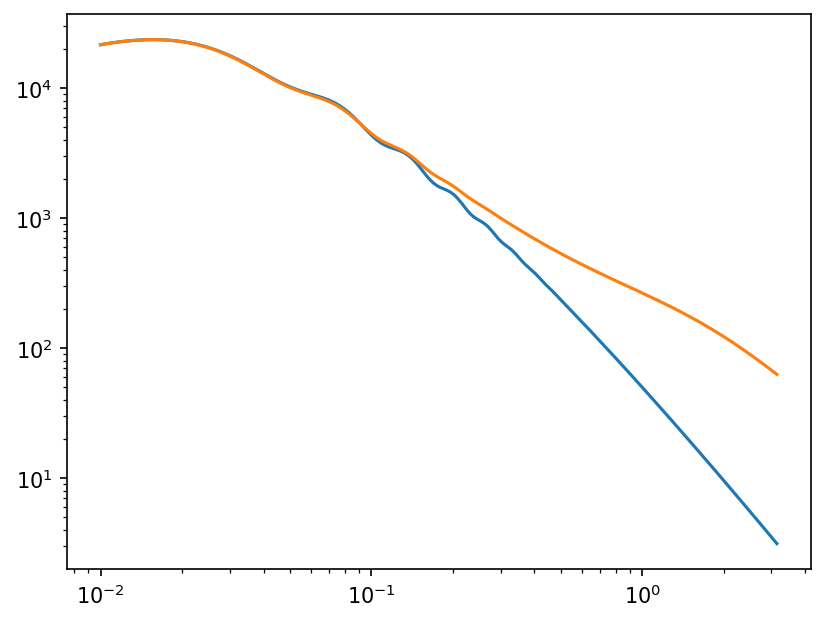

In [11]:
plt.loglog(kk, pk_lin_data[0])

plt.loglog(kk, pk_nlin_data[0])
  

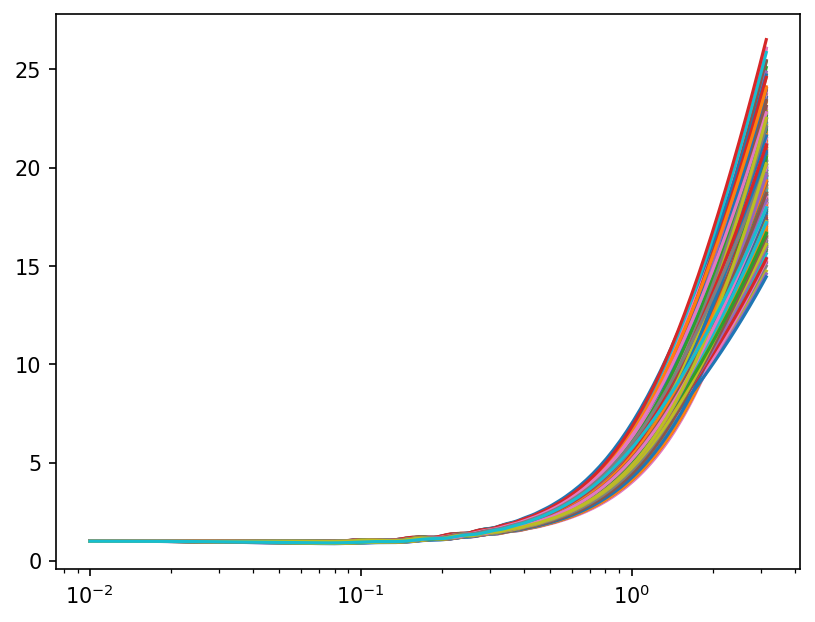

In [12]:
for i in range(400):
    plt.semilogx(kk, (pk_nlin_data/pk_lin_data)[i])

In [13]:
pk_baumann_smeared= _smeared_bao_pk(k_lin=kk, pk_lin=pk_lin_data[233], k_emu=kk, pk_lin_emu=pk_lin_data[233])

In [14]:
pk_baumann = _nowiggles_pk(k_lin=kk, pk_lin=pk_lin_data[233], k_emu=kk)

In [15]:
 pk_joao= smooth_bao(kk, pk_lin_data[233])

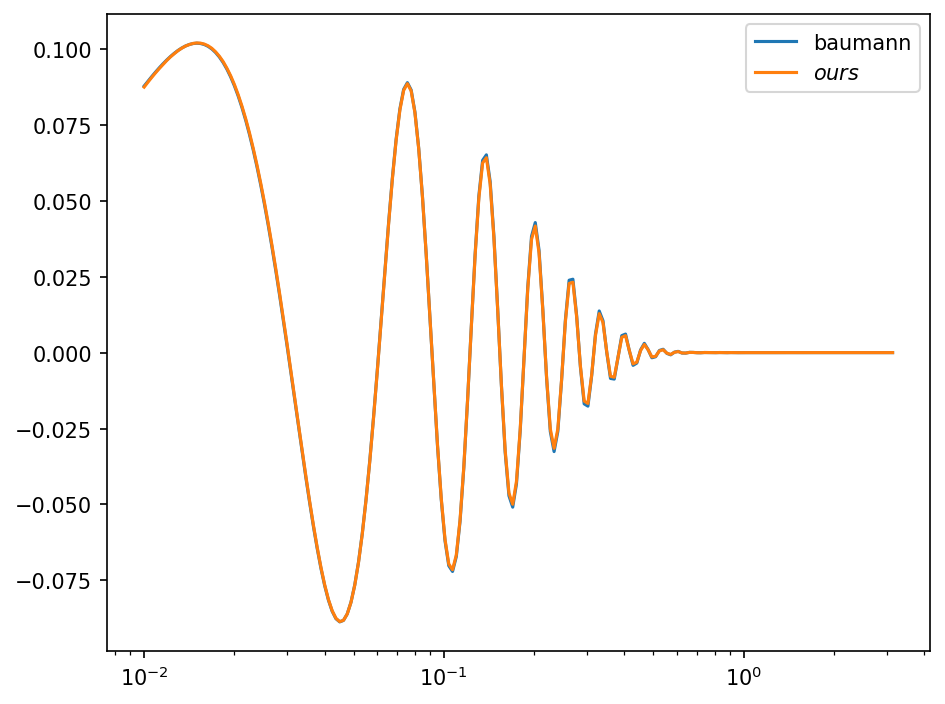

In [16]:
i=17
plt.semilogx(kk, pk_lin_data[i]/_nowiggles_pk(k_lin=kk, pk_lin=pk_lin_data[i]  , k_emu=kk) -1  , label='baumann' )
plt.semilogx(kk, pk_lin_data[i]/smooth_bao(kk, pk_lin_data[i])-1, label='$ours$' )
#plt.semilogx(kk, pk_lin_ref/pk_baumann2- 1 , label='10^10' )

#plt.semilogx(kk, 100*pk_baumann_smeared2/pk_baumann_smeared - 100  , label='% error' )


plt.tight_layout()

plt.legend()

Text(0, 0.5, '$P(k) \\,\\,\\,\\, [\\mathrm{Mpc}/h]^3$')

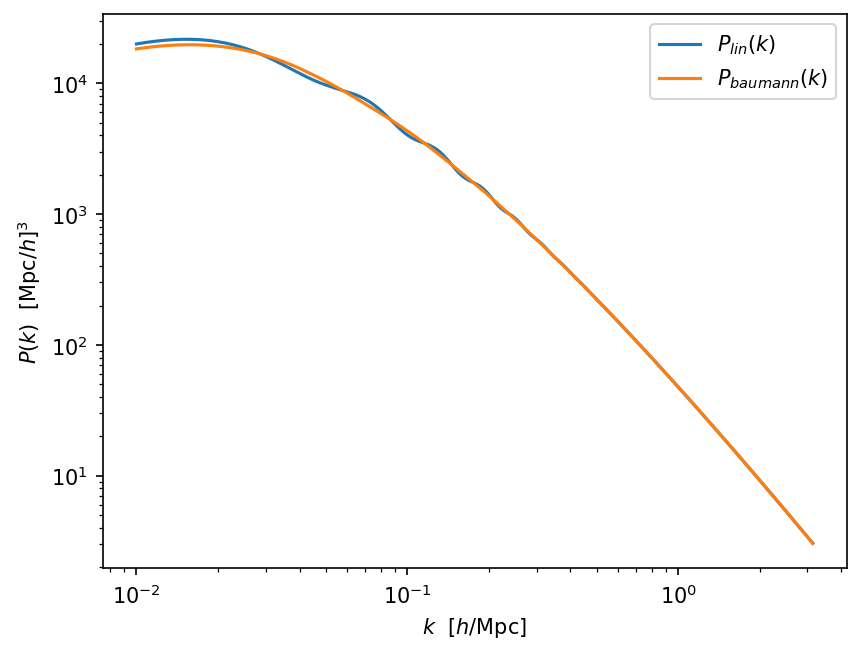

In [17]:
#plt.loglog(kk, demo_pk, label='$P_{nw}(k)$' )
plt.loglog(kk, pk_lin_data[233], label='$P_{lin}(k)$' )
plt.loglog(kk, pk_joao, label='$P_{baumann}(k)$' )
#plt.loglog(kk,pk_baumann_smeared)
#plt.loglog(kk,pk_smeared_data[0])
plt.legend()

plt.xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k) \,\,\,\, [\mathrm{Mpc}/h]^3$')


Text(0, 0.5, '$P(k) \\,\\,\\,\\, [\\mathrm{Mpc}/h]^3$')

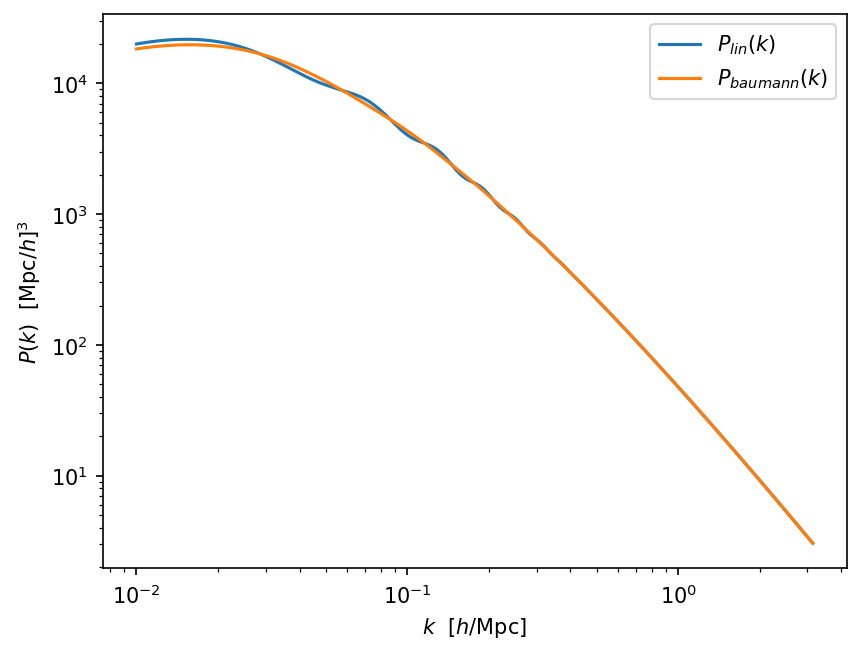

In [18]:
#plt.loglog(kk, demo_pk, label='$P_{nw}(k)$' )
plt.loglog(kk, pk_lin_data[233], label='$P_{lin}(k)$' )
plt.loglog(kk, pk_baumann, label='$P_{baumann}(k)$' )
#plt.loglog(kk,pk_baumann_smeared)
#plt.loglog(kk,pk_smeared_data[0])
plt.legend()

plt.xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k) \,\,\,\, [\mathrm{Mpc}/h]^3$')


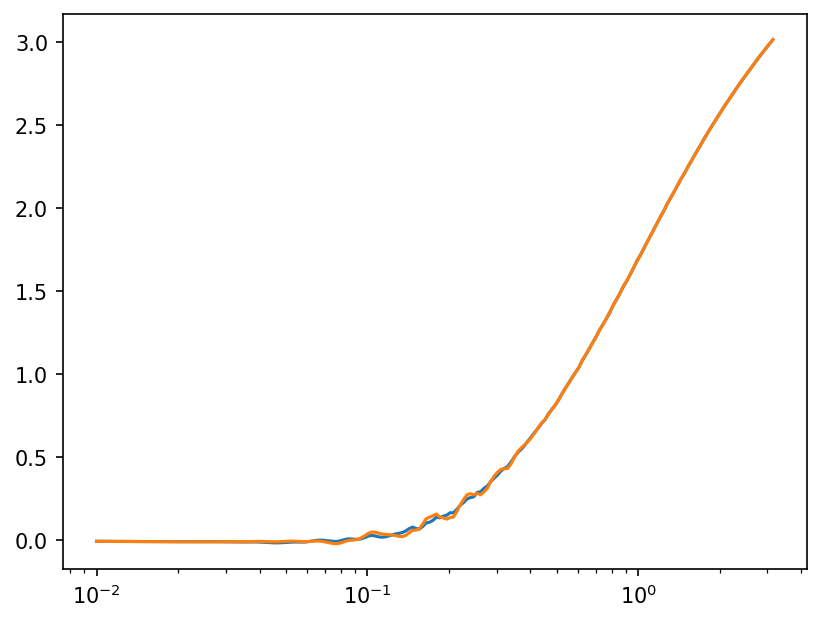

In [19]:
plt.semilogx(kk, boost_emu[0])
plt.semilogx(kk, np.log(b_case[0]))

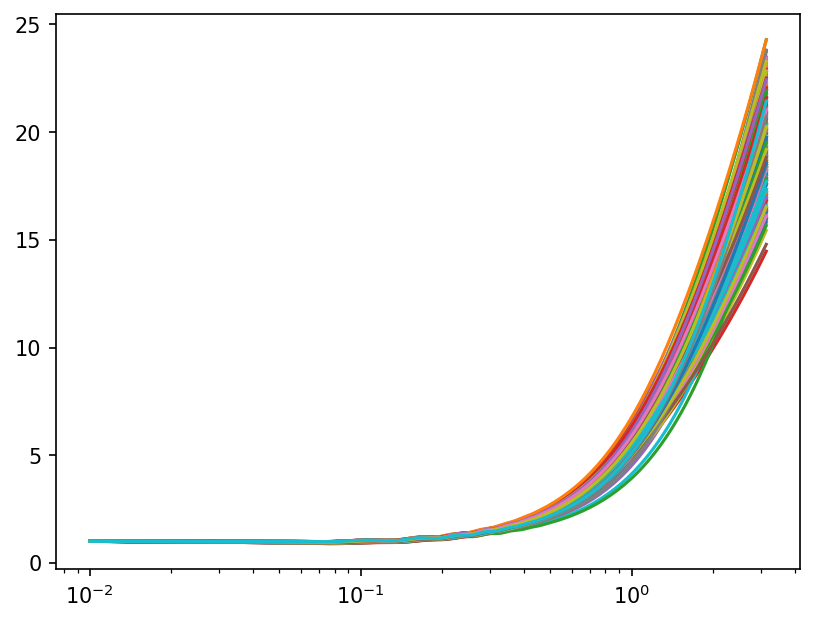

In [20]:
for i in range(300):
    plt.semilogx(kk, (pk_nlin_data_test/pk_lin_data_test)[i])
 


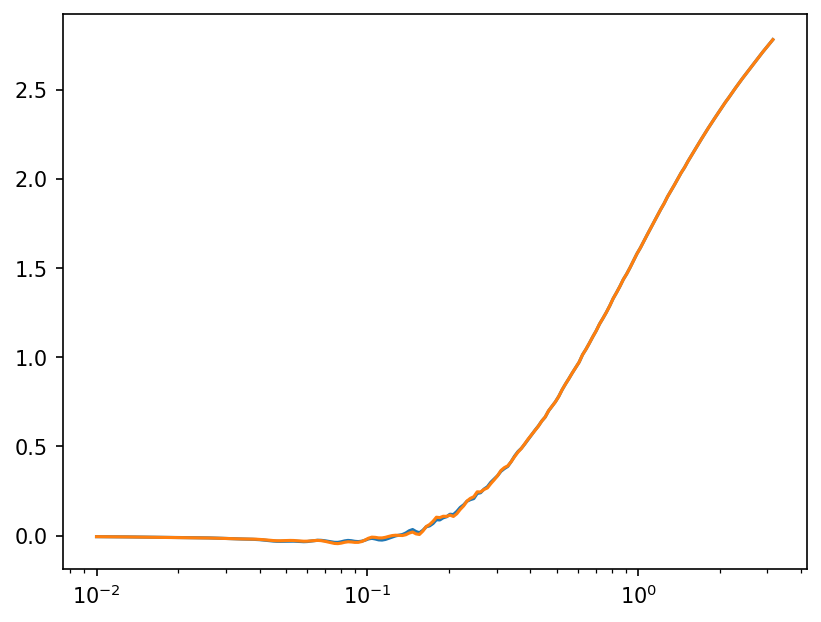

In [21]:
plt.semilogx(kk, boost_emu_test[0])
plt.semilogx(kk, np.log(b_case_test[0]))

In [22]:
scaler_emu_data = MinMaxScaler(feature_range=(-1, 1))
scaler_emu_data.fit(np.array(emu_function_train))
scaled_emu_train=scaler_emu_data.transform(np.array(emu_function_train))

In [23]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(np.array(lhs_train))
scaledparam=scaler.transform(np.array(lhs_train))
scaledteste=scaler.transform(np.array(lhs_test)) # scaler.transform(np.array(np.array([0.3,0.04,0.96605,2.1e-09,67.32/100]).reshape(1, -1))) #  
samples=np.array(scaledparam).T
  

In [24]:
teste,  xsmeared = PCA_trans_and_inv(emu_function_train_norm, 11)  
 

In [25]:
teste_unnorm= unnormalize_array(teste, emu_function_train)

Text(0.5, 1.0, 'LCDM halofit pca error - our code mod')

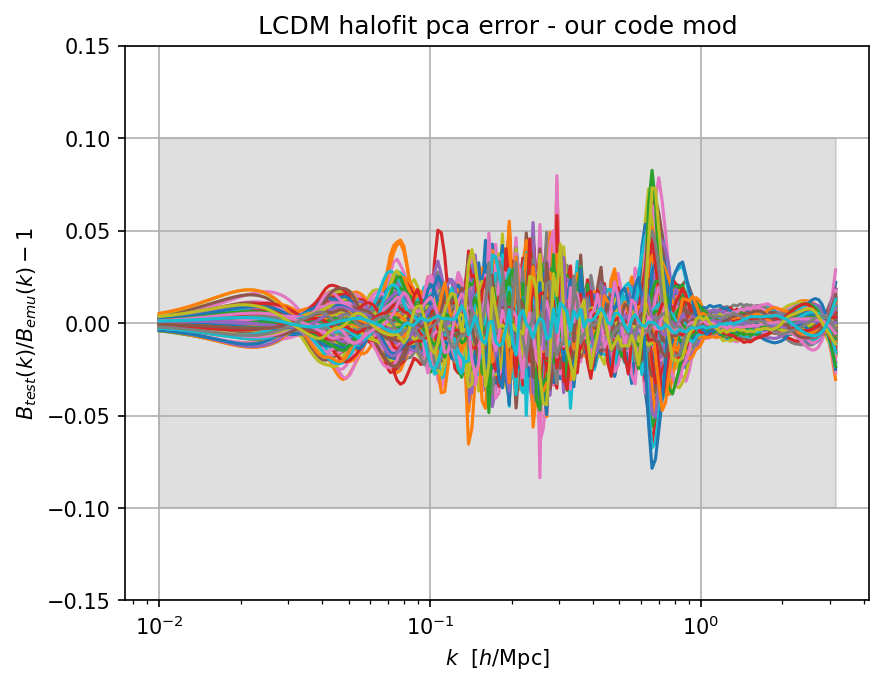

In [36]:
for i in range(emu_function_train.shape[0]):
    plt.semilogx(kk[:500],100*(np.exp(emu_function_train)[i]/np.exp(teste_unnorm)[i]) -100, label="keras prediction")
        
percent = 0.1
plt.fill_between(kk, -percent, percent, color = 'gray', alpha = 0.25, label = f'${percent}\%$')
plt.grid()
plt.ylim(-0.15,0.15)

plt.xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$B_{test}(k)/B_{emu}(k) - 1 \,\,\,\,$')
plt.title(r'LCDM halofit pca error - our code mod')

In [27]:
 

X = expansion9(*samples).T 
#X= X / (np.linalg.norm(X,axis = 0))
y = xsmeared#[:,0].reshape(-1,1)
#y= y / (np.linalg.norm(y,axis = 0))
Y=y


X.shape

n_samples, n_features = X.shape
n_targets = y.shape[1]
n_tasks = y.shape[1]

#alpha = 1e-6

#l1_ratio = 0.9

#alpha = 1e-5 z=0

#l1_ratio = 0.05 z = 0 

alpha = 0.02e-4

l1_ratio = 0.1



l1_reg =  alpha *  l1_ratio * n_samples
l2_reg =  alpha * (1.0 -  l1_ratio) * n_samples

coef_ = np.zeros(
                (n_targets, n_features), dtype=X.dtype.type, order="F"
            )

coef_ = np.asfortranarray(coef_)    #np.random.randn(12, n_features) #np.asfortranarray(coef_) 
W = coef_

max_iter=10
tol=0.0000001
gap = tol + 1.0

XtA = np.zeros((n_features, n_tasks), dtype=X.dtype.type)

R = np.zeros((n_samples, n_tasks), dtype=X.dtype.type, order='F')

norm_cols_X = np.zeros(n_features, dtype=X.dtype.type)
tmp = np.zeros(n_tasks, dtype=X.dtype.type)
w_ii = np.zeros(n_tasks, dtype=X.dtype.type) 

norm_cols_X = (np.asarray(X)**2).sum(axis=0)

R = Y - np.dot(X, W.T)

tol = tol * np.linalg.norm(Y, ord='fro') ** 2

poly shape: (4368,)
parameter common shape: (400,)
output shape: (4368, 400)


In [28]:
W = np.asfortranarray(W ) 
X = np.asfortranarray(X ) 
R = np.asfortranarray(R ) 
norm_cols_X = np.asfortranarray(norm_cols_X) 

In [29]:
for i in tqdm(range(500)): 
                     

    regfortran___2.test10(n_features, 1,l1_reg,l2_reg, 
    W ,
    X,R,norm_cols_X)
 
    

100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 87.94it/s]


In [38]:
Xboost_iselfevals = PCA_transinv(emu_function_train_norm, 11, (X@W.T))

In [39]:
Xboost_iselfevals_rescaled = unnormalize_array(Xboost_iselfevals, emu_function_train)

Text(0.5, 1.0, 'LCDM halofit emulation error - our code mod ')

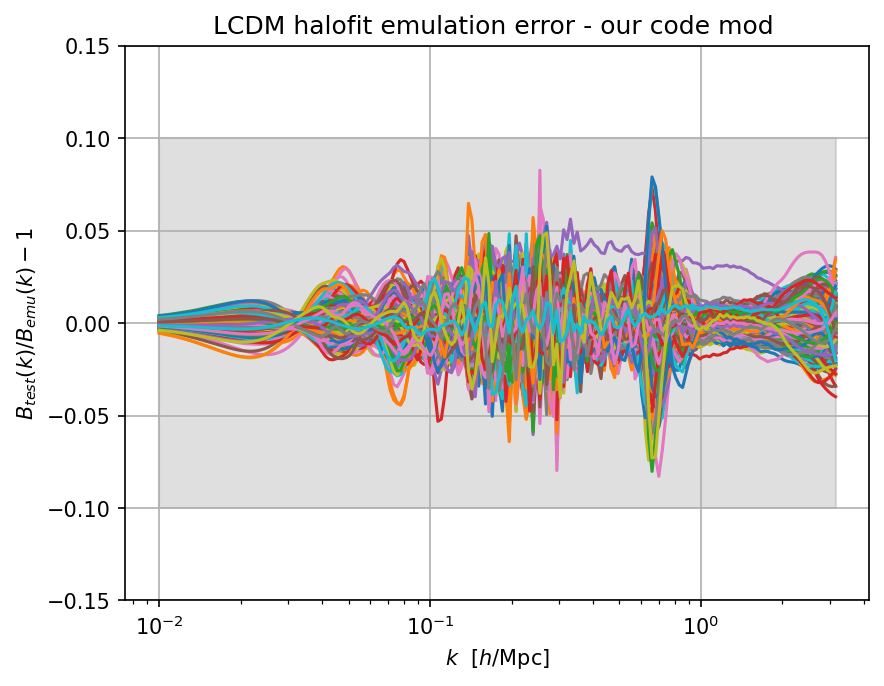

In [40]:
boost_txt=[]
for i in range(emu_function_train.shape[0]):
    plt.semilogx(kk ,100*((np.exp(Xboost_iselfevals_rescaled[i]  ))/(np.exp(emu_function_train[i]  ))) - 100  , label="ultimo lhs")
    boost_txt.append(((np.exp(Xboost_iselfevals_rescaled[i] ))/(np.exp(emu_function_train[i] ))) - 1 )
percent = 0.1
plt.fill_between(kk, -percent, percent, color = 'gray', alpha = 0.25, label = f'${percent}\%$')
plt.grid()
plt.ylim(-0.15,0.15)

plt.xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$B_{test}(k)/B_{emu}(k) - 1 \,\,\,\,$')
plt.title(r'LCDM halofit emulation error - our code mod ')

In [33]:
Xboost_iselfevals = PCA_transinv(emu_function_train_norm,11, (expansion9(*scaledteste.T).T)@W.T)

poly shape: (4368,)
parameter common shape: (300,)
output shape: (4368, 300)


In [34]:
 Xboost_iselfevals_rescaled = unnormalize_array(Xboost_iselfevals, emu_function_train)
    
    
     
   

Text(0.5, 1.0, 'LCDM halofit test error - our code mod')

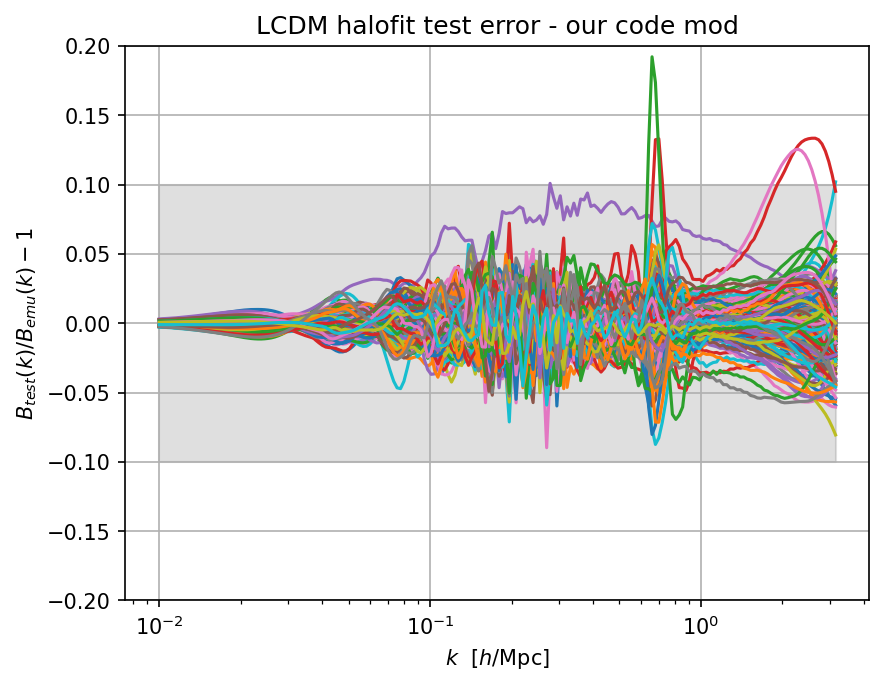

In [35]:
error_bs=[]
boost_txt=[]

for i in range(emu_function_test.shape[0]):
    plt.semilogx(kk[:500],100*(np.exp(Xboost_iselfevals_rescaled[i])/np.exp(emu_function_test[i] ))  - 100  , label="ultimo lhs")
    boost_txt.append((np.exp(Xboost_iselfevals_rescaled[i])/np.exp(emu_function_test[i] ))  - 1 )

    error_bs.append( 100*(np.exp(Xboost_iselfevals_rescaled)/np.exp(emu_function_test))[i] - 100)
percent = 0.1
plt.fill_between(kk, -percent, percent, color = 'gray', alpha = 0.25, label = f'${percent}\%$')
plt.grid()
plt.ylim(-0.2,0.2)

plt.xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$B_{test}(k)/B_{emu}(k) - 1 \,\,\,\,$')
plt.title(r'LCDM halofit test error - our code mod')